In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [39]:
def min_max_scale(x):
    return (x - x.min())/(x.max() - x.min())

In [154]:
import scipy

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson


from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col


In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

from src.utils import get_statsmodels_tab

In [6]:
from src.utils import get_stars

In [7]:
def get_statsmodels_var_summary(var, col_name: int = 1, **kwargs):
    summary = pd.DataFrame(var.pvalues.stack(), columns=['pval'])
    summary['coef'] = np.concatenate([np.ones(var.neqs), var.coefs.ravel()])
    summary['stder'] = var.stderr.unstack().values
    summary['stars'] = summary.pval.map(get_stars)
    
    lst_txt = []
    for i, row in summary.round(3).iterrows():
        lst_txt.append( f"{row['coef']}{row['stars']}\n[{row['stder']}]" )
    summary['txt'] = lst_txt
    
    columns = [(col_name, i) for i in summary.columns]
    summary.columns = pd.MultiIndex.from_tuples(columns)
    
    return summary

def get_statmodels_var_summary_joint(lst_of_vars, lst_of_names = None, **kwargs):
    if lst_of_names is None:
        lst_of_names = [*range(len(lst_of_vars))]
    lst_summaries = [get_statsmodels_var_summary(var, col_name=lst_of_names[i]) for i, var in enumerate(lst_of_vars)]
    df = lst_summaries[0]
    for i, summary in enumerate(lst_summaries[1:]):
        df = df.join(summary, how='outer')
    
    
    return df

# load data

In [8]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)

topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [9]:
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war',
        'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY',
        'pi_exp_MY', 'i_exp_MY', 'pi_exp_WY', 'riskaversion'
    ]].drop_duplicates().copy()
df = pd_join_dfs([df, hhp.set_index('date_forecast')[['pi_exp_MY', 'i_exp_MY', 'pi_exp_WY']].drop_duplicates().add_suffix("_F"),],
                 index_name='date_recorded')

In [10]:
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y']], 'M', True)

df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()
df = df.reset_index(drop=True)

In [11]:
# check

In [12]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    49546.000000
mean         1.937573
std          1.801603
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

# plot data

In [13]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()

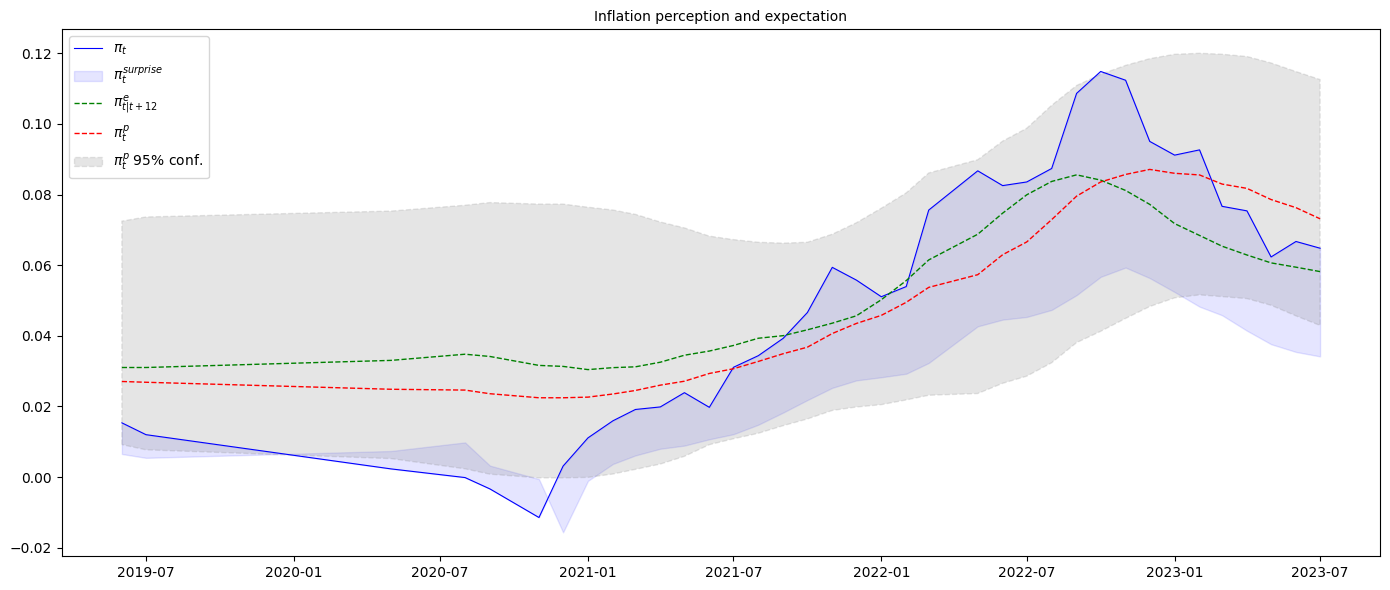

In [14]:
fig, ax = plt.subplots(1,1, figsize=(14,6))

ax.plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax.fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
# ax.plot(sub['pi_de_estimate_Y'], linestyle='dashed',)

ax.plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax.plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax.fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^p_{t}$ 95% conf.')

ax.set_title('Inflation perception and expectation', size=10)
ax.legend(loc='upper left', )
fig.tight_layout()

save_fig(fig, 'plot_inflation.png')

# Expectation and perception

In [15]:
# get pi percption error
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=7)
df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [16]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i])
lst_error_cols

['delta_pe_MY_error_act',
 'delta_pe_MY_error_mse',
 'pi_exp_MY_error_act',
 'pi_exp_MY_error_mse',
 'pi_perc_MY_all_error_act',
 'pi_perc_MY_all_error_mse',
 'pi_perc_MY_error_act',
 'pi_perc_MY_error_mse']

## Perception error: What explains the perception error in the cross-section

In [103]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (10748, 2)
delta_pe_MY_error_mse (10748, 2)
pi_exp_MY_error_act (10976, 2)
pi_exp_MY_error_mse (10976, 2)
pi_perc_MY_all_error_act (22478, 2)
pi_perc_MY_all_error_mse (22478, 2)
pi_perc_MY_error_act (7629, 2)
pi_perc_MY_error_mse (7629, 2)


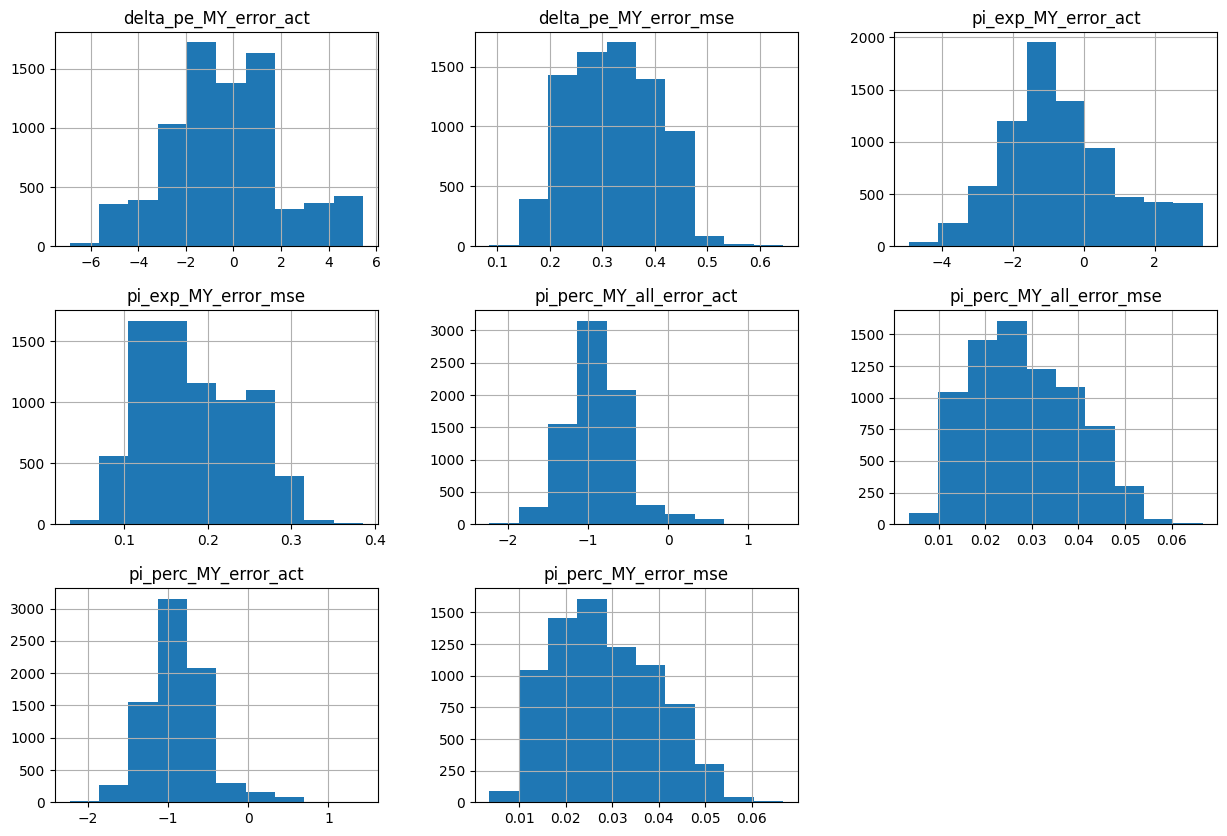

In [104]:
df[['id', *lst_error_cols]].drop_duplicates().drop('id', axis=1).dropna().hist(figsize=(15,10));

In [105]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
sub = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        # 'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'wealth_bank_midpoint', 
        # 'savings_planned', 
        'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        # 'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
sub = sub.join(_).reset_index().groupby('id').last()

In [75]:
DICT_PARSE_COLS.update({'hhsize': 'category', 'profession_txt': 'category', 'savings_planned': int, 'riskaversion': "category"})
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
sub = pd_df_astype(sub, DICT_PARSE_COLS)

In [76]:
ols_data = sub.copy()
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col], prefix=col)
        # dummies.columns = [i.split(' ')[0] for i in dummies.columns]
        ols_data = ols_data.join(dummies.iloc[:, :-1])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [77]:
# multiple ols models
lst_ols_mods = []
for col in lst_error_cols:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    d = d.dropna()
    print(d.shape)
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    lst_ols_mods.append(ols)

(3364, 20)
(3364, 20)
(3491, 20)
(3491, 20)
(6015, 20)
(6015, 20)
(1820, 20)
(1820, 20)


In [78]:
summary_col(lst_ols_mods, stars=True)

,delta_pe_MY_error_act,delta_pe_MY_error_mse,pi_exp_MY_error_act,pi_exp_MY_error_mse,pi_perc_MY_all_error_act,pi_perc_MY_all_error_mse,pi_perc_MY_error_act,pi_perc_MY_error_mse
is_food_shop,-0.1102,-0.0138,0.0944,-0.0152***,-0.1039**,-0.0032***,0.0834*,-0.0031***
,(0.2040),(0.0086),(0.1385),(0.0051),(0.0411),(0.0009),(0.0428),(0.0012)
profession_txt_Angestellte,0.0104,0.0106**,0.0252,0.0074***,0.0031,0.0001,-0.0102,0.0007
,(0.0999),(0.0042),(0.0692),(0.0026),(0.0211),(0.0005),(0.0221),(0.0006)
profession_txt_Arbeiter,-0.0805,0.0010,-0.0666,0.0028,0.1407***,-0.0007,0.0201,0.0008
,(0.2090),(0.0088),(0.1463),(0.0054),(0.0443),(0.0010),(0.0454),(0.0012)
profession_txt_Auszubildende,0.1108,0.0205,0.0044,0.0234,0.2454*,-0.0057*,-0.4844*,0.0167**
,(1.1746),(0.0493),(0.8296),(0.0308),(0.1476),(0.0032),(0.2474),(0.0068)
"profession_txt_Beamtin (inkl. Richter, Berufssoldaten)",-0.1314,0.0076,-0.1184,0.0076,-0.0067,0.0010,-0.0555,-0.0000
,(0.2052),(0.0086),(0.1426),(0.0053),(0.0424),(0.0009),(0.0473),(0.0013)


In [22]:
x = get_statsmodels_tab(lst_ols_mods)
save_pd_df(x[3], 'text.csv', GRAPHS_DIR)

## risk aversion delta_pe

In [17]:
sub = df[['id', 'riskaversion', 'delta_pe_MY_error_act']].drop_duplicates().dropna().copy()

In [18]:
# plt.plot(
#     sub.set_index(['riskaversion', 'id']).delta_pe_MY_error_act.sort_index().unstack(),
#     lw=0,
#     marker='o',
#     alpha=.3,
#     color='grey',
# )
# ;

In [19]:
# sub.groupby('riskaversion').delta_pe_MY_error_act.mean().plot()

## Test errors in time series dimension

In [17]:
for col in [('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act')]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [18]:
arr = df.set_index('date_recorded').delta_pe_MY_error_act_WY.drop_duplicates().values * 100
arr = df.set_index('date_recorded').pi_perc_MY_all_error_act_WY.drop_duplicates().values * 100

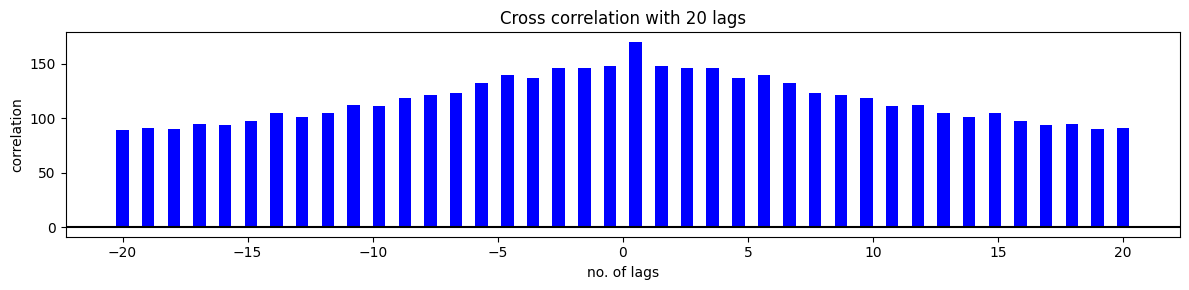

In [19]:
cross_corr(arr, arr, lags=20);

### pi perc

<AxesSubplot: xlabel='M'>

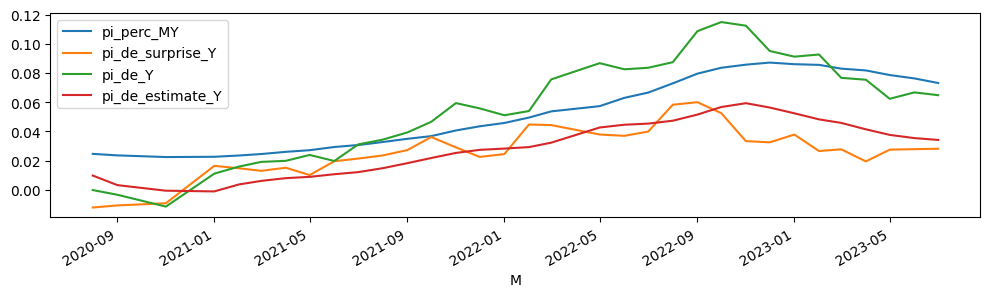

In [66]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
sub.plot()

In [67]:
cols_endog, cols_exog = ['pi_perc_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var1 = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)
# print(var1.summary())

In [70]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit().summary()

pi_perc_MY ADF p-val: 0.018553484289268035
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
5 1


,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_perc_MY,0.7504,0.141,5.315,0.000,0.474,1.027
L1.pi_de_surprise_Y,0.1101,0.041,2.676,0.007,0.029,0.191
L1.pi_de_estimate_Y,0.3174,0.117,2.706,0.007,0.087,0.547
,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_perc_MY,3.1958,0.918,3.479,0.001,1.396,4.996
L1.pi_de_surprise_Y,0.4325,0.268,1.615,0.106,-0.092,0.957
L1.pi_de_estimate_Y,0.4196,0.763,0.550,0.582,-1.076,1.915
,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_perc_MY,0.3463,0.157,2.203,0.028,0.038,0.654
L1.pi_de_surprise_Y,-0.1044,0.046,-2.278,0.023,-0.194,-0.015


### pi perc error

<AxesSubplot: xlabel='M'>

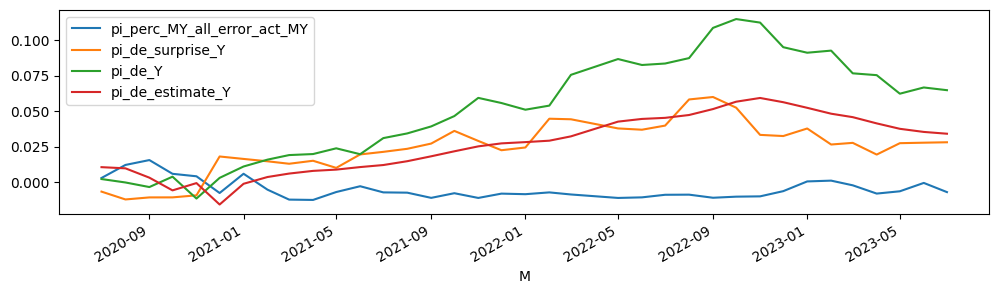

In [71]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY_all_error_act_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
sub.plot()

In [72]:
cols_endog, cols_exog = ['pi_perc_MY_all_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var1 = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2, ic='fpe')
# print(var1.summary())

In [73]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit().summary()

pi_perc_MY_all_error_act_MY ADF p-val: 0.09312812377193597
pi_de_surprise_Y ADF p-val: 0.3017349697248496
pi_de_estimate_Y ADF p-val: 0.7825207762316098
1
5 2


,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_perc_MY_all_error_act_MY,0.1470,0.156,0.943,0.346,-0.159,0.453
L1.pi_de_surprise_Y,0.1146,0.214,0.535,0.593,-0.305,0.535
L1.pi_de_estimate_Y,-0.5907,0.196,-3.015,0.003,-0.975,-0.207
L2.pi_perc_MY_all_error_act_MY,-0.4474,0.143,-3.128,0.002,-0.728,-0.167
L2.pi_de_surprise_Y,0.1914,0.181,1.056,0.291,-0.164,0.547
L2.pi_de_estimate_Y,0.7438,0.198,3.749,0.000,0.355,1.133
,coef,std err,z,P>|z|,[0.025,0.975]
L1.pi_perc_MY_all_error_act_MY,-0.2611,0.319,-0.818,0.413,-0.887,0.364
L1.pi_de_surprise_Y,1.1494,0.439,2.620,0.009,0.290,2.009
L1.pi_de_estimate_Y,0.9599,0.401,2.394,0.017,0.174,1.746


### delta exp

<AxesSubplot: xlabel='M'>

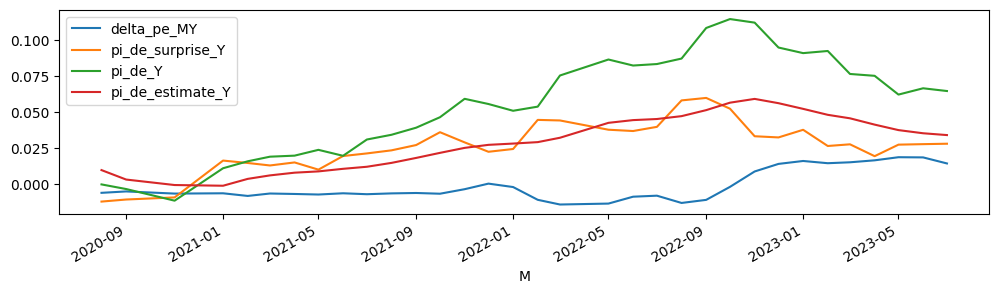

In [74]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
sub.plot()

In [75]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']

In [76]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit().summary()

delta_pe_MY ADF p-val: 0.44313200381795326
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
5 1


,coef,std err,z,P>|z|,[0.025,0.975]
L1.delta_pe_MY,0.4922,0.178,2.770,0.006,0.144,0.840
L1.pi_de_surprise_Y,-0.1141,0.106,-1.079,0.280,-0.321,0.093
L1.pi_de_estimate_Y,0.0830,0.307,0.270,0.787,-0.519,0.685
,coef,std err,z,P>|z|,[0.025,0.975]
L1.delta_pe_MY,-0.8714,0.454,-1.919,0.055,-1.761,0.019
L1.pi_de_surprise_Y,0.1073,0.270,0.397,0.691,-0.422,0.637
L1.pi_de_estimate_Y,-0.4169,0.785,-0.531,0.595,-1.955,1.121
,coef,std err,z,P>|z|,[0.025,0.975]
L1.delta_pe_MY,-0.0100,0.071,-0.141,0.888,-0.149,0.129
L1.pi_de_surprise_Y,-0.1294,0.042,-3.076,0.002,-0.212,-0.047


### delta exp error

<AxesSubplot: xlabel='M'>

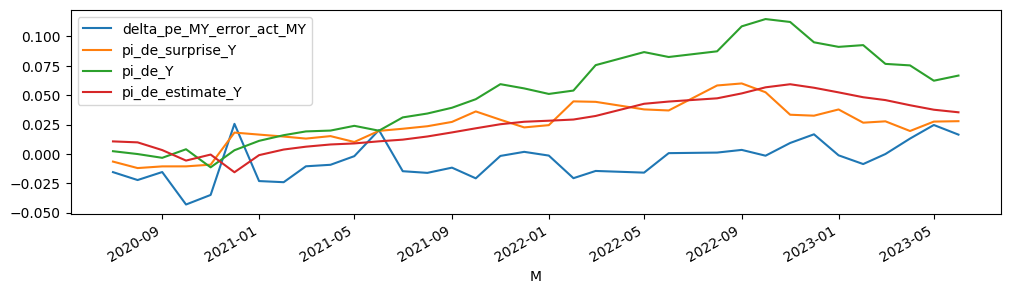

In [77]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY_error_act_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
sub.plot()

In [85]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit().summary()

delta_pe_MY_error_act_MY ADF p-val: 0.9509824412702439
pi_de_surprise_Y ADF p-val: 0.0535354526734725
pi_de_estimate_Y ADF p-val: 0.8029480317761679
2
5 1


,coef,std err,z,P>|z|,[0.025,0.975]
L1.delta_pe_MY_error_act_MY,0.1968,0.158,1.243,0.214,-0.113,0.507
L1.pi_de_surprise_Y,0.0597,0.404,0.148,0.882,-0.731,0.851
L1.pi_de_estimate_Y,1.5973,0.612,2.610,0.009,0.398,2.797
,coef,std err,z,P>|z|,[0.025,0.975]
L1.delta_pe_MY_error_act_MY,0.2300,0.098,2.351,0.019,0.038,0.422
L1.pi_de_surprise_Y,0.4838,0.249,1.940,0.052,-0.005,0.973
L1.pi_de_estimate_Y,0.6986,0.378,1.847,0.065,-0.043,1.440
,coef,std err,z,P>|z|,[0.025,0.975]
L1.delta_pe_MY_error_act_MY,-0.0510,0.027,-1.896,0.058,-0.104,0.002
L1.pi_de_surprise_Y,-0.3495,0.069,-5.094,0.000,-0.484,-0.215


# News analysis

## overview on news and narratives

In [31]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

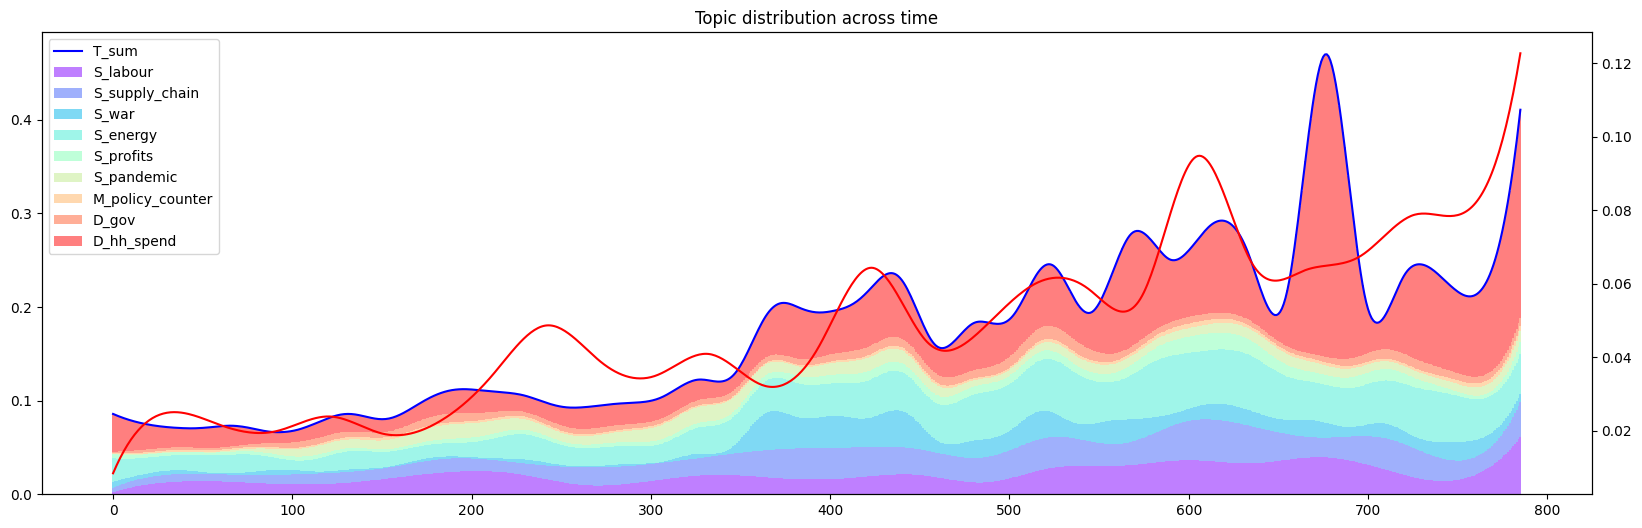

In [32]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
ax.twinx().plot(sub.D_inflation.values, color='green', label='D_inflation')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left");

In [33]:
# fig, ax = plt_stacked_bar(
#     sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
# )
# ax.legend()
# ;

## PCA

In [230]:
X = topics_raw.drop(['D_inflation'], axis=1).diff().copy().dropna()
X = topics.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).diff().copy().dropna()

scaler = StandardScaler().fit(X)
X_std = pd.DataFrame(scaler.transform(X), X.index, X.columns)
pca = PCA(n_components=5).fit(X_std)

NameError: name 'StandardScaler' is not defined

In [ ]:
fig, ax = plt_stacked_bar(pd.DataFrame(pca.components_, columns = X.columns))
ax.legend(X.columns)

In [ ]:
fig, ax = plt.subplots()

ax.plot(X.index, (pca.components_ @ X_std.T).T.sum(axis=1), label='agg pca');
ax2 = ax.twinx()
ax2.plot(topics.T_sum_diff_lag.dropna(), color='red', label='T_sum_diff')
ax.legend()
ax2.legend(loc='upper right')
plt.title('Components across time')

In [ ]:
topics = topics.join(pd.Series((pca.components_ @ X_std.T).T.sum(axis=1), index=X.index, name='T_pca_sum_diff'))
topics['T_pca_sum'] = topics.T_pca_sum_diff.cumsum()

In [ ]:
df = pd_join_freq(
    df.set_index('date_recorded'), 
    topics[['T_pca_sum_diff', 'T_pca_sum']].apply(lambda x: (x - x.min())/(x.max() - x.min())).copy(),
    'W', True)

df = df.reset_index(drop=True)

## war and inflation as given by hh concern

In [38]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']

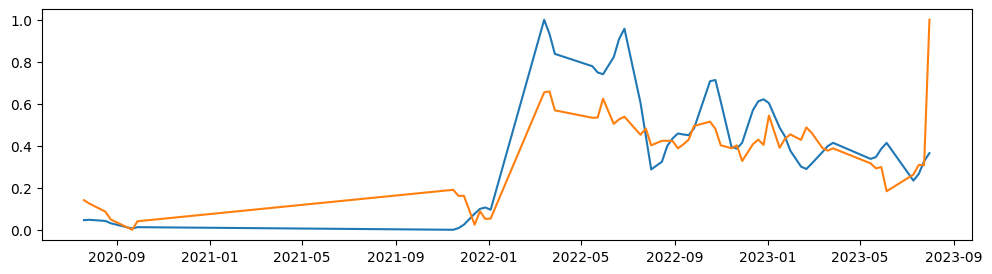

In [221]:
plt.plot(sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x)))
sub[cols_endog + cols_exog] = sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x))

In [222]:
var = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2)
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Mar, 2024
Time:                     15:15:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.46404
Nobs:                     56.0000    HQIC:                  -7.68549
Log likelihood:           70.1987    FPE:                0.000399717
AIC:                     -7.82571    Det(Omega_mle):     0.000336875
--------------------------------------------------------------------
Results for equation S_war
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.006040         0.020788            0.291           0.771
L1.S_war                0.130153         0.199316            0.653           0.514
L1.percprob_war        -0.141955         0.296111   

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Macro analysis

## VECM: Does surprise inflation elicit higher news-paper reporting?

Following Dräger (2015) VECM to analyse:
$$ X_t = \Gamma X_{t-1} + u_t $$ 
where
$$X_t = (\pi_t, \pi^p_t, \pi^e_{t-12}, \Delta N_{t-1})$$

### with inflation monthly

(34, 5)

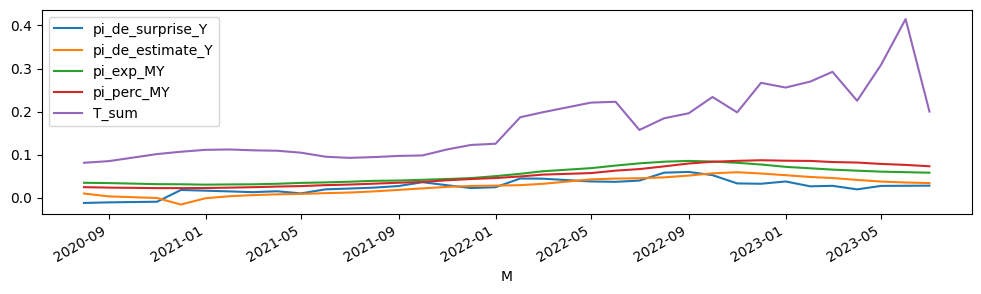

In [99]:
sub = pd_groupby(df.set_index('date_recorded'), ['pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub.plot();
sub.shape

In [101]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=1).fit()
# vecm.summary()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
3
3 0


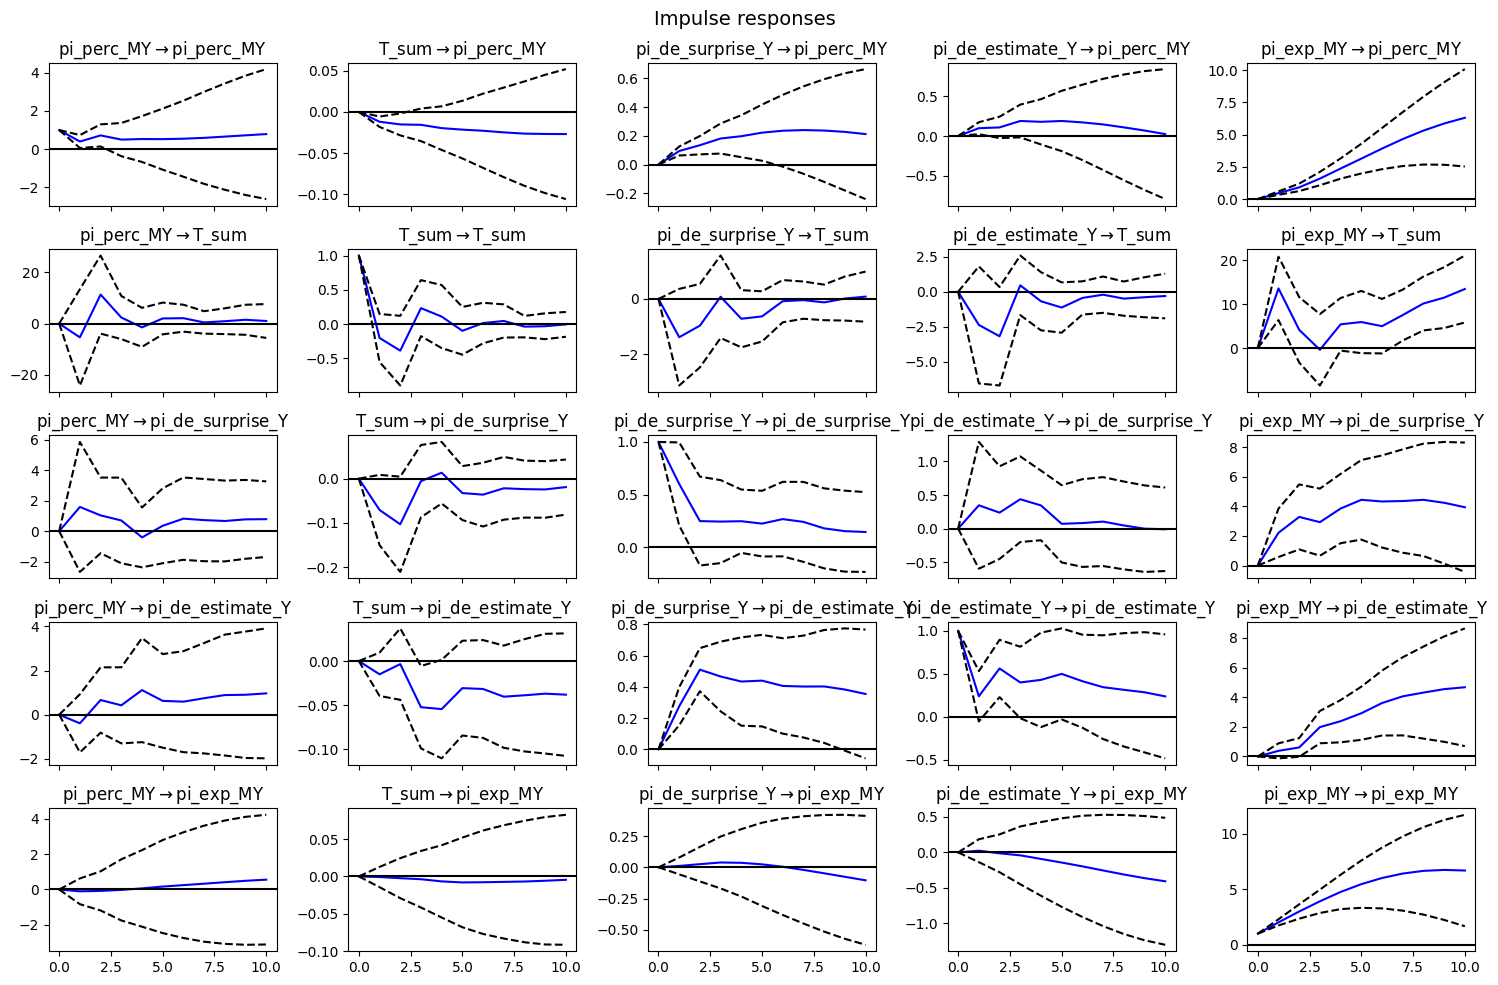

In [104]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

### without inflation

In [108]:
sub = df.groupby('week_recorded')[['pi_exp_WY', 'pi_perc_WY', 'T_sum']].last().dropna()
sub.shape

(92, 3)

In [111]:
cols_endog, cols_exog = ['pi_perc_WY'], ['T_sum', 'pi_exp_WY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=1).fit()
# vecm.summary()

pi_perc_WY ADF p-val: 0.014219717000384888
T_sum ADF p-val: 0.9278081776736748
pi_exp_WY ADF p-val: 0.512861519793435
2
3 2


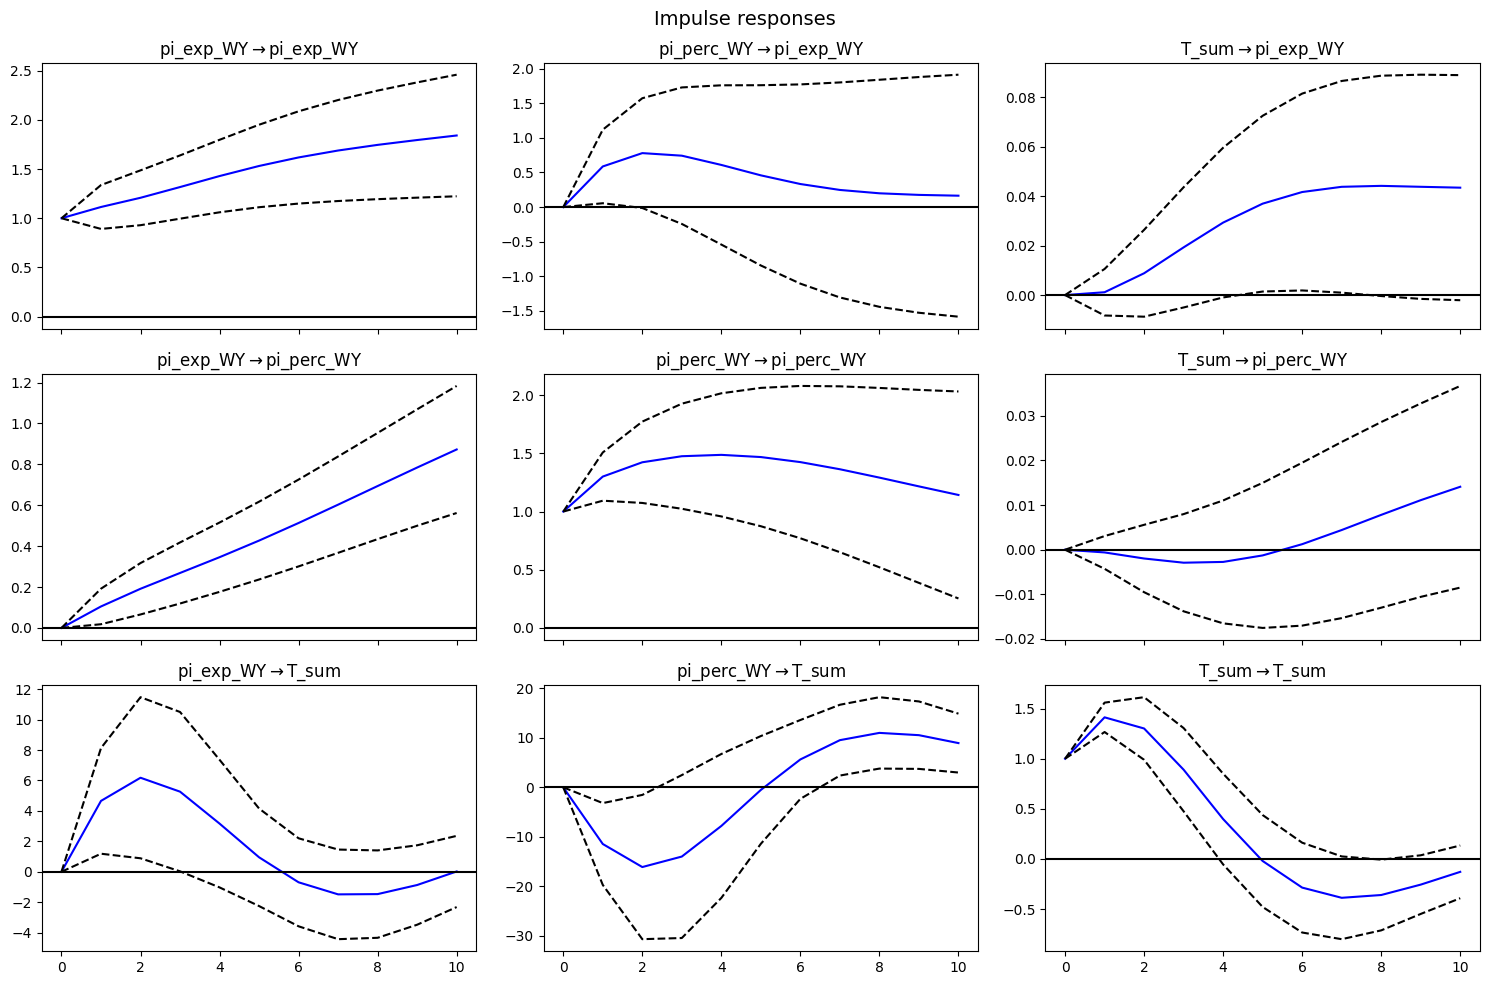

In [114]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

## VAR: Does surprise inflation elicit higher news-paper reporting?

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [119]:
sub = pd_groupby(df.set_index('date_recorded'), [ 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [120]:
var = VAR(sub_d).fit()
# var.summary()

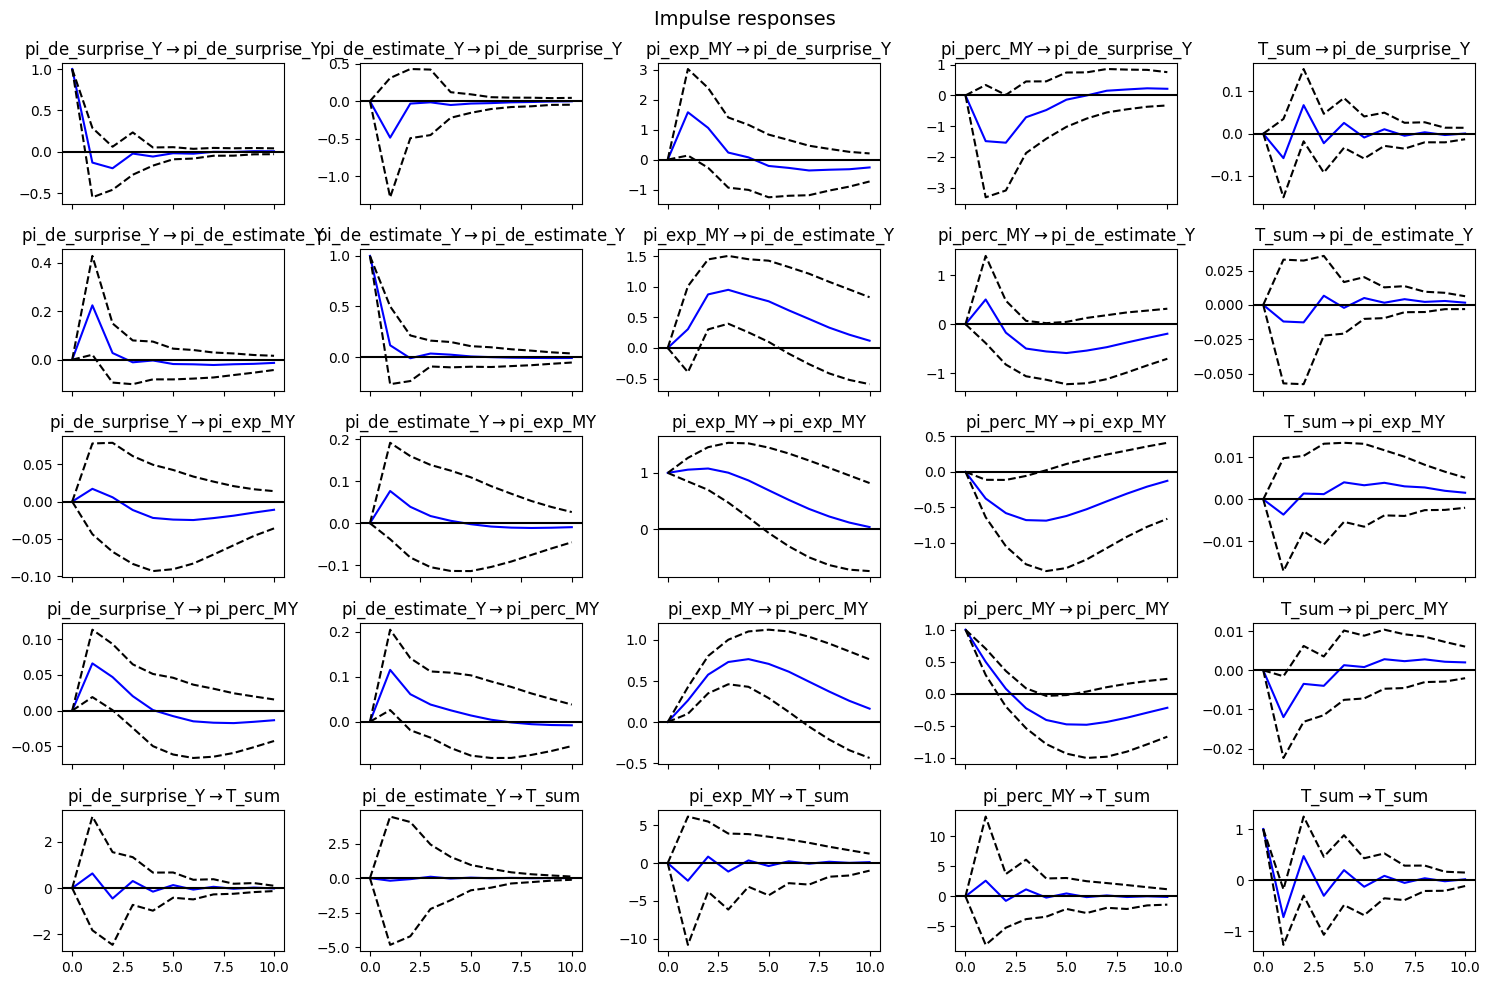

In [121]:
var.irf().plot(figsize=(15,10))
plt.tight_layout()

# Micro analysis

In [201]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [202]:
df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

In [152]:
_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [205]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
    }
)

In [206]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [207]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [209]:
dist = df.groupby('id')[['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust']].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
# dist = scipy.spatial.distance.cdist(dist, dist.mean(axis=0).values[None])
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

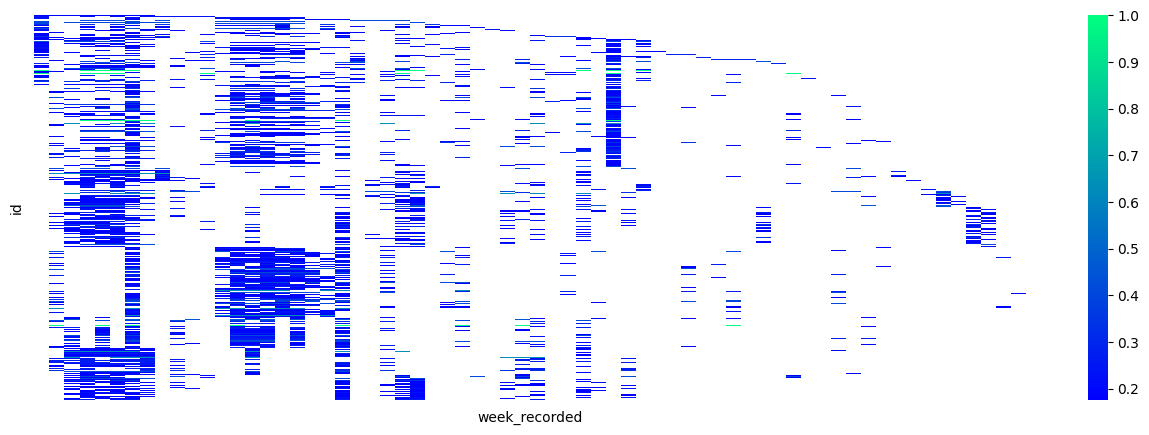

In [210]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

fig = plt.figure(figsize=(16,5))
sns.heatmap(A, xticklabels=False, yticklabels=False, cmap='winter')

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [211]:
cols = ['T_sum_diff_lag', 'hhinc', 'pi_de_Y', 'is_unempl',] # 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [212]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 5), 1492)

In [161]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                pi_perc   R-squared:                        0.2580
Estimator:                   PanelOLS   R-squared (Between):              0.8040
No. Observations:                8055   R-squared (Within):               0.2580
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.7510
Time:                        15:46:16   Log-likelihood                 2.009e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      151.80
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                 F(15,6548)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             131.53
                            

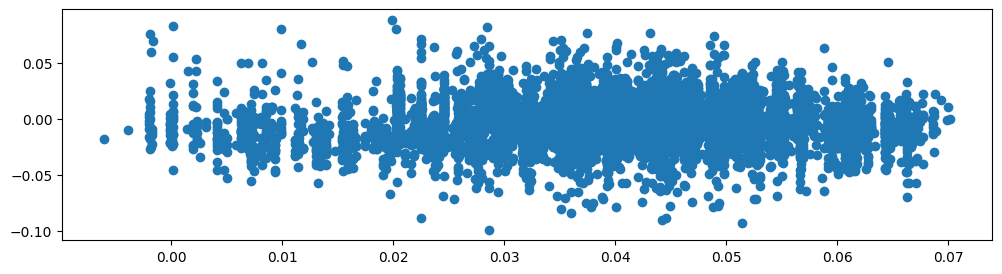

In [162]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [163]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 109.1957241778076, 'LM p-val': 1.080209178139093e-22, 'F-Stat': 27.656910147726887, 'F p-val': 7.689086948782225e-23}


In [164]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.0029516411291644


In [165]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 44.86704058303371
degrees of freedom: 15
p-Value: 8.036073195602008e-05


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [166]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y', 'debt', 'is_unempl', 'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [167]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2982, 7), 715)

In [168]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               delta_pe   R-squared:                        0.0524
Estimator:                   PanelOLS   R-squared (Between):             -7.1849
No. Observations:                2982   R-squared (Within):               0.0524
Date:                Wed, Mar 27 2024   R-squared (Overall):             -1.2833
Time:                        15:46:32   Log-likelihood                    9175.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6385
Entities:                         715   P-value                           0.0000
Avg Obs:                       4.1706   Distribution:                 F(22,2245)
Min Obs:                       4.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.543
                            

In [169]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 510.9521106085888, 'LM p-val': 3.674761691882483e-107, 'F-Stat': 102.52617493348329, 'F p-val': 1.247217174020557e-117}


In [170]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.1744810405531907


In [171]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 237.59000063708717
degrees of freedom: 22
p-Value: 4.3056138794273853e-38


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [174]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [175]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((29619, 4), 4300)

In [176]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 pi_exp   R-squared:                        0.4398
Estimator:                   PanelOLS   R-squared (Between):              0.8507
No. Observations:               29619   R-squared (Within):               0.4398
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.8014
Time:                        15:46:51   Log-likelihood                 7.752e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6624.9
Entities:                        4300   P-value                           0.0000
Avg Obs:                       6.8881   Distribution:                 F(3,25316)
Min Obs:                       6.0000                                           
Max Obs:                       12.000   F-statistic (robust):             3964.8
                            

In [177]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 120.75848270961693, 'LM p-val': 5.297613746115009e-26, 'F-Stat': 40.4121543239461, 'F p-val': 4.7205822432122384e-26}


In [178]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

1.9869566194668744


In [179]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 468.9347857900488
degrees of freedom: 3
p-Value: 2.5735022448138416e-101


## Exp 4

In [217]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [218]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 4), 1492)

In [219]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:          pi_perc_error   R-squared:                        0.3184
Estimator:                   PanelOLS   R-squared (Between):             -4.3152
No. Observations:                8055   R-squared (Within):               0.3184
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.8175
Time:                        15:52:50   Log-likelihood                 2.008e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1021.5
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                  F(3,6560)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             855.44
                            

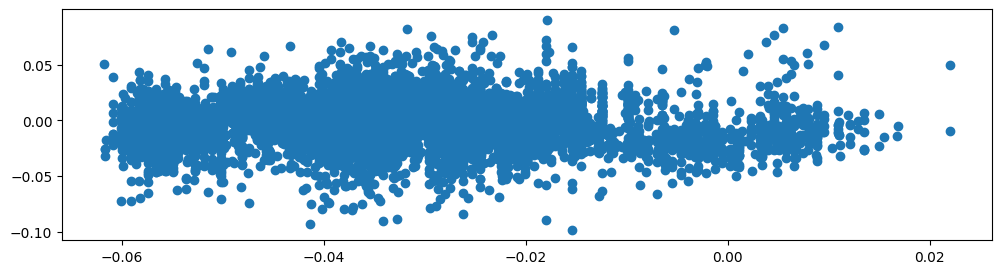

In [220]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [221]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 104.1791315219897, 'LM p-val': 1.9621389302204236e-22, 'F-Stat': 35.16392423533056, 'F p-val': 1.433350641350051e-22}


In [222]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.001561105798445


In [223]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 931.4046277496547
degrees of freedom: 3
p-Value: 1.3646763405726904e-201


## Exp 5

In [245]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe_error']

In [246]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((45794, 4), 7279)

In [247]:
sub = sub.loc[~sub.duplicated()]

In [248]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:         delta_pe_error   R-squared:                        0.8543
Estimator:                   PanelOLS   R-squared (Between):              0.9753
No. Observations:                2872   R-squared (Within):               0.8543
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.9714
Time:                        15:54:51   Log-likelihood                    9918.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2359.9
Entities:                        1662   P-value                           0.0000
Avg Obs:                       1.7280   Distribution:                  F(3,1207)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             2929.4
                            

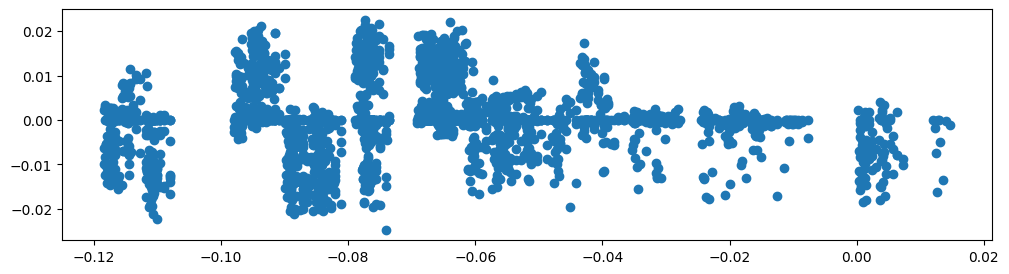

In [249]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [250]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 64.81053334521283, 'LM p-val': 5.50664050030162e-14, 'F-Stat': 22.07149557021431, 'F p-val': 3.973376952388344e-14}


In [251]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.1546787752309653


In [252]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 25.861867544949117
degrees of freedom: 3
p-Value: 1.0194101898097498e-05
